**Set environment**

In [1]:
suppressMessages(suppressWarnings(source("../run_config_project_sing.R")))
show_env()

You are working on        Singularity 
BASE DIRECTORY (FD_BASE): /mount 
REPO DIRECTORY (FD_REPO): /mount/repo 
WORK DIRECTORY (FD_WORK): /mount/work 
DATA DIRECTORY (FD_DATA): /mount/data 

You are working with      ENCODE FCC 
PATH OF PROJECT (FD_PRJ): /mount/repo/Proj_ENCODE_FCC 
PROJECT RESULTS (FD_RES): /mount/repo/Proj_ENCODE_FCC/results 
PROJECT SCRIPTS (FD_EXE): /mount/repo/Proj_ENCODE_FCC/scripts 
PROJECT DATA    (FD_DAT): /mount/repo/Proj_ENCODE_FCC/data 
PROJECT NOTE    (FD_NBK): /mount/repo/Proj_ENCODE_FCC/notebooks 
PROJECT DOCS    (FD_DOC): /mount/repo/Proj_ENCODE_FCC/docs 
PROJECT LOG     (FD_LOG): /mount/repo/Proj_ENCODE_FCC/log 
PROJECT APP     (FD_APP): /mount/repo/Proj_ENCODE_FCC/app 
PROJECT REF     (FD_REF): /mount/repo/Proj_ENCODE_FCC/references 



In [2]:
txt_region = "fcc_astarr_macs_input_overlap"
txt_fdiry  = file.path(FD_RES, "region_integration", txt_region)
txt_fname  = "result.coverage.ranknorm.whg.tsv"
txt_fpath  = file.path(txt_fdiry, txt_fname)

dat = read_tsv(txt_fpath, show_col_types = FALSE)
dat_region_starrmpra_ranknorm = dat

print(dim(dat))
fun_display_table(head(dat, 3))

[1] 60618     5


Region,ASTARR,LMPRA,WSTARR,Mean
chr1:100036895-100039189,0.9032466,0.9352832,0.9627008,0.9337436
chr1:100048290-100048918,0.0495727,0.0133706,0.0349896,0.0326443
chr1:100050225-100050529,0.7499258,0.0718681,0.8012307,0.5410082


In [3]:
dat = dat_region_starrmpra_ranknorm
dat = dat %>% dplyr::arrange(Mean)

VEC_TXT_REGION = dat$Region
VEC_TXT_ASSAY  = c("ASTARR", "WSTARR", "LMPRA")
head(dat, 3)

Region,ASTARR,LMPRA,WSTARR,Mean
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
chr11:119493738-119494104,0.0013692303,0.002458016,0.0002804448,0.001369230
chr12:109020860-109021302,0.0003629285,0.003612788,0.0051469860,0.003040901
chr2:112821224-112821459,0.0018641328,0.008182388,0.0003959220,0.003480814


In [4]:
dat = dat_region_starrmpra_ranknorm
dat = dat %>%
    dplyr::select(-Mean) %>%
    tidyr::gather(Assay, Score, -Region) %>% 
    dplyr::mutate(
        Assay  = factor(Assay,  levels=VEC_TXT_ASSAY),
        Region = factor(Region, levels=VEC_TXT_REGION),
    )

dat_score_starrmpra = dat
print(dim(dat))
head(dat)

[1] 181854      3


Region,Assay,Score
<fct>,<fct>,<dbl>
chr1:100036895-100039189,ASTARR,0.90324656
chr1:100048290-100048918,ASTARR,0.04957273
chr1:100050225-100050529,ASTARR,0.74992576
chr1:100132375-100133491,ASTARR,0.98051734
chr1:10015258-10016191,ASTARR,0.34964862
chr1:100248956-100250290,ASTARR,0.80720248


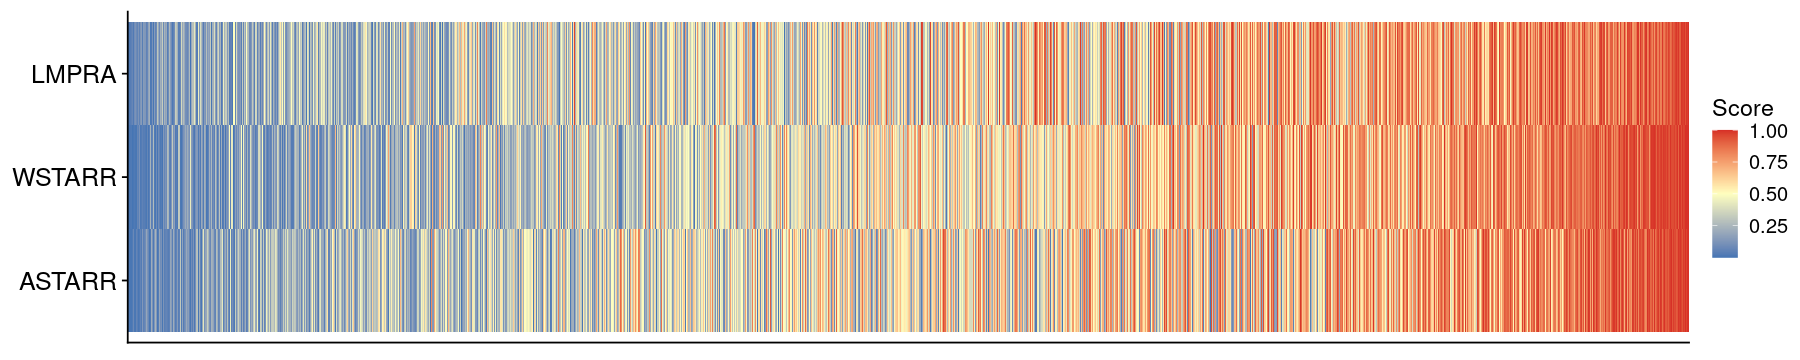

In [5]:
theme_fill = scale_fill_gradient2(
    low  = "#4575b4",
    mid  = "#ffffbf",
    high = "#d73027",
    midpoint = 0.5
)

theme_text = theme(
    axis.ticks.x = element_blank(),
    axis.text.x  = element_blank(),
    axis.text.y  = element_text(size = 15),
    #axis.title.x = element_text(size = 20),
    axis.title.x = element_blank(),
    axis.title.y = element_blank()
)

theme_legend = theme(legend.position = "none")

dat = dat_score_starrmpra

gpt = ggplot(dat, aes(x=Region, y=Assay, fill=Score)) +
    geom_tile() +
    labs(x="Open Chromatin Regions") +
    theme_cowplot() + 
    theme_text +
    theme_fill

gpt_score_starrmpra = gpt + theme(legend.position = "none")

options(repr.plot.height=3, repr.plot.width=15)
print(gpt)

In [6]:
txt_fdiry = file.path(
    FD_RES, 
    "region_annotation", 
    "fcc_astarr_macs_input_overlap",
    "summary"
)
txt_fname = "result.summary.chipseq_flagship.tsv"
txt_fpath = file.path(txt_fdiry, txt_fname)

dat = read_tsv(txt_fpath, show_col_types = FALSE)

dat_region_annot_chipseq = dat
head(dat)

Chrom,ChromStart,ChromEnd,Region,Group,Label
<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>
chr1,10038,10405,chr1:10038-10405,ChIP-seq:Histone,CREBBP
chr1,10038,10405,chr1:10038-10405,ChIP-seq:Histone,HMBOX1
chr1,10038,10405,chr1:10038-10405,ChIP-seq:Histone,ZBTB33
chr1,16025,16338,chr1:16025-16338,ChIP-seq:Histone,CTCF
chr1,16025,16338,chr1:16025-16338,ChIP-seq:Histone,RAD21
chr1,17288,17689,chr1:17288-17689,ChIP-seq:Histone,POLR2A


In [7]:
vec = c("CREBBP", "HMBOX1", "ZBTB33", "CTCF")
dat = dat_region_annot_chipseq
dat = dat %>% dplyr::filter(Label %in% vec)
dat_region_annot_chipseq_subset = dat

In [8]:
fun_corr = function(x, y){
    fit     = glm(y ~ x, family = "binomial")
    num_cor = cor(x, y, method = "spearman")
    num_acc = sum(round(predict(fit, type = "response")) == y) / length(y)

    res = c(num_cor, num_acc)
    names(res) = c("Correlation", "Accuracy")
    return(res)
}

In [9]:
dat = dat_region_annot_chipseq_subset
dat = dat %>%
    dplyr::select(Region, Label) %>%
    dplyr::mutate(Value = 1) %>%
    dplyr::filter(Region %in% VEC_TXT_REGION) %>%
    dplyr::mutate(
        Region = factor(Region, levels=VEC_TXT_REGION)
    )

dat_region_annot = dat
print(dim(dat))
head(dat)

[1] 47505     3


Region,Label,Value
<fct>,<chr>,<dbl>
chr1:138321-139517,CTCF,1
chr1:267910-268557,CTCF,1
chr1:778233-779389,CTCF,1
chr1:903783-905204,CTCF,1
chr1:903783-905204,ZBTB33,1
chr1:920937-921509,CTCF,1


In [10]:
dat = dat_region_starrmpra_ranknorm
dat = dat %>% dplyr::select(Region, Mean)
dat_region_mean = dat
head(dat)

Region,Mean
<chr>,<dbl>
chr1:100036895-100039189,0.93374355
chr1:100048290-100048918,0.03264432
chr1:100050225-100050529,0.54100817
chr1:100132375-100133491,0.91814588
chr1:10015258-10016191,0.16646046
chr1:100248956-100250290,0.72932407


In [11]:
dat = dat_region_annot
lst = split(dat, dat$Label)
lst = lapply(lst, function(dat){
    txt = unique(dat$Label)
    dat = dplyr::left_join(dat_region_mean, dat, by = "Region")
    dat = dat %>% dplyr::mutate(Label = txt)
    dat = dat %>% replace(is.na(.), 0)
    return(dat)
})
lst_merge = lst

In [12]:
dat = lst[[1]]
head(dat)

Region,Mean,Label,Value
<chr>,<dbl>,<chr>,<dbl>
chr1:100036895-100039189,0.93374355,CREBBP,0
chr1:100048290-100048918,0.03264432,CREBBP,0
chr1:100050225-100050529,0.54100817,CREBBP,0
chr1:100132375-100133491,0.91814588,CREBBP,0
chr1:10015258-10016191,0.16646046,CREBBP,0
chr1:100248956-100250290,0.72932407,CREBBP,0


In [13]:
lst = lst_merge
lst = lapply(lst, function(dat){
    x   = as.numeric(dat$Mean)
    y   = as.numeric(dat$Value)
    res = fun_corr(x, y)
    return(res)
})

dat = bind_rows(lst, .id="Label")
dat = dat %>% dplyr::arrange(Correlation)
head(dat)

Label,Correlation,Accuracy
<chr>,<dbl>,<dbl>
CTCF,-0.16133043,0.5830116
CREBBP,0.02102159,0.9988287
ZBTB33,0.13591443,0.8644627
HMBOX1,0.15766187,0.7999769


In [14]:
vec_txt_label = dat$Label

In [15]:
dat = dat_region_annot
dat = dat %>%
    dplyr::mutate(
        Region = factor(Region, levels=VEC_TXT_REGION),
        Label  = factor(Label,  levels=vec_txt_label)
    ) %>%
    dplyr::mutate(Value = as.character(Value))

In [16]:
THEME_TEXT = theme(
    axis.ticks.x = element_blank(),
    axis.text.x  = element_blank(),
    axis.text.y  = element_text(size = 15),
    axis.title.x = element_blank(),
    axis.title.y = element_blank(),
    plot.title = element_text(face = "bold", size = 17)
    #plot.title = element_text(face = "plain", size = 17)
)

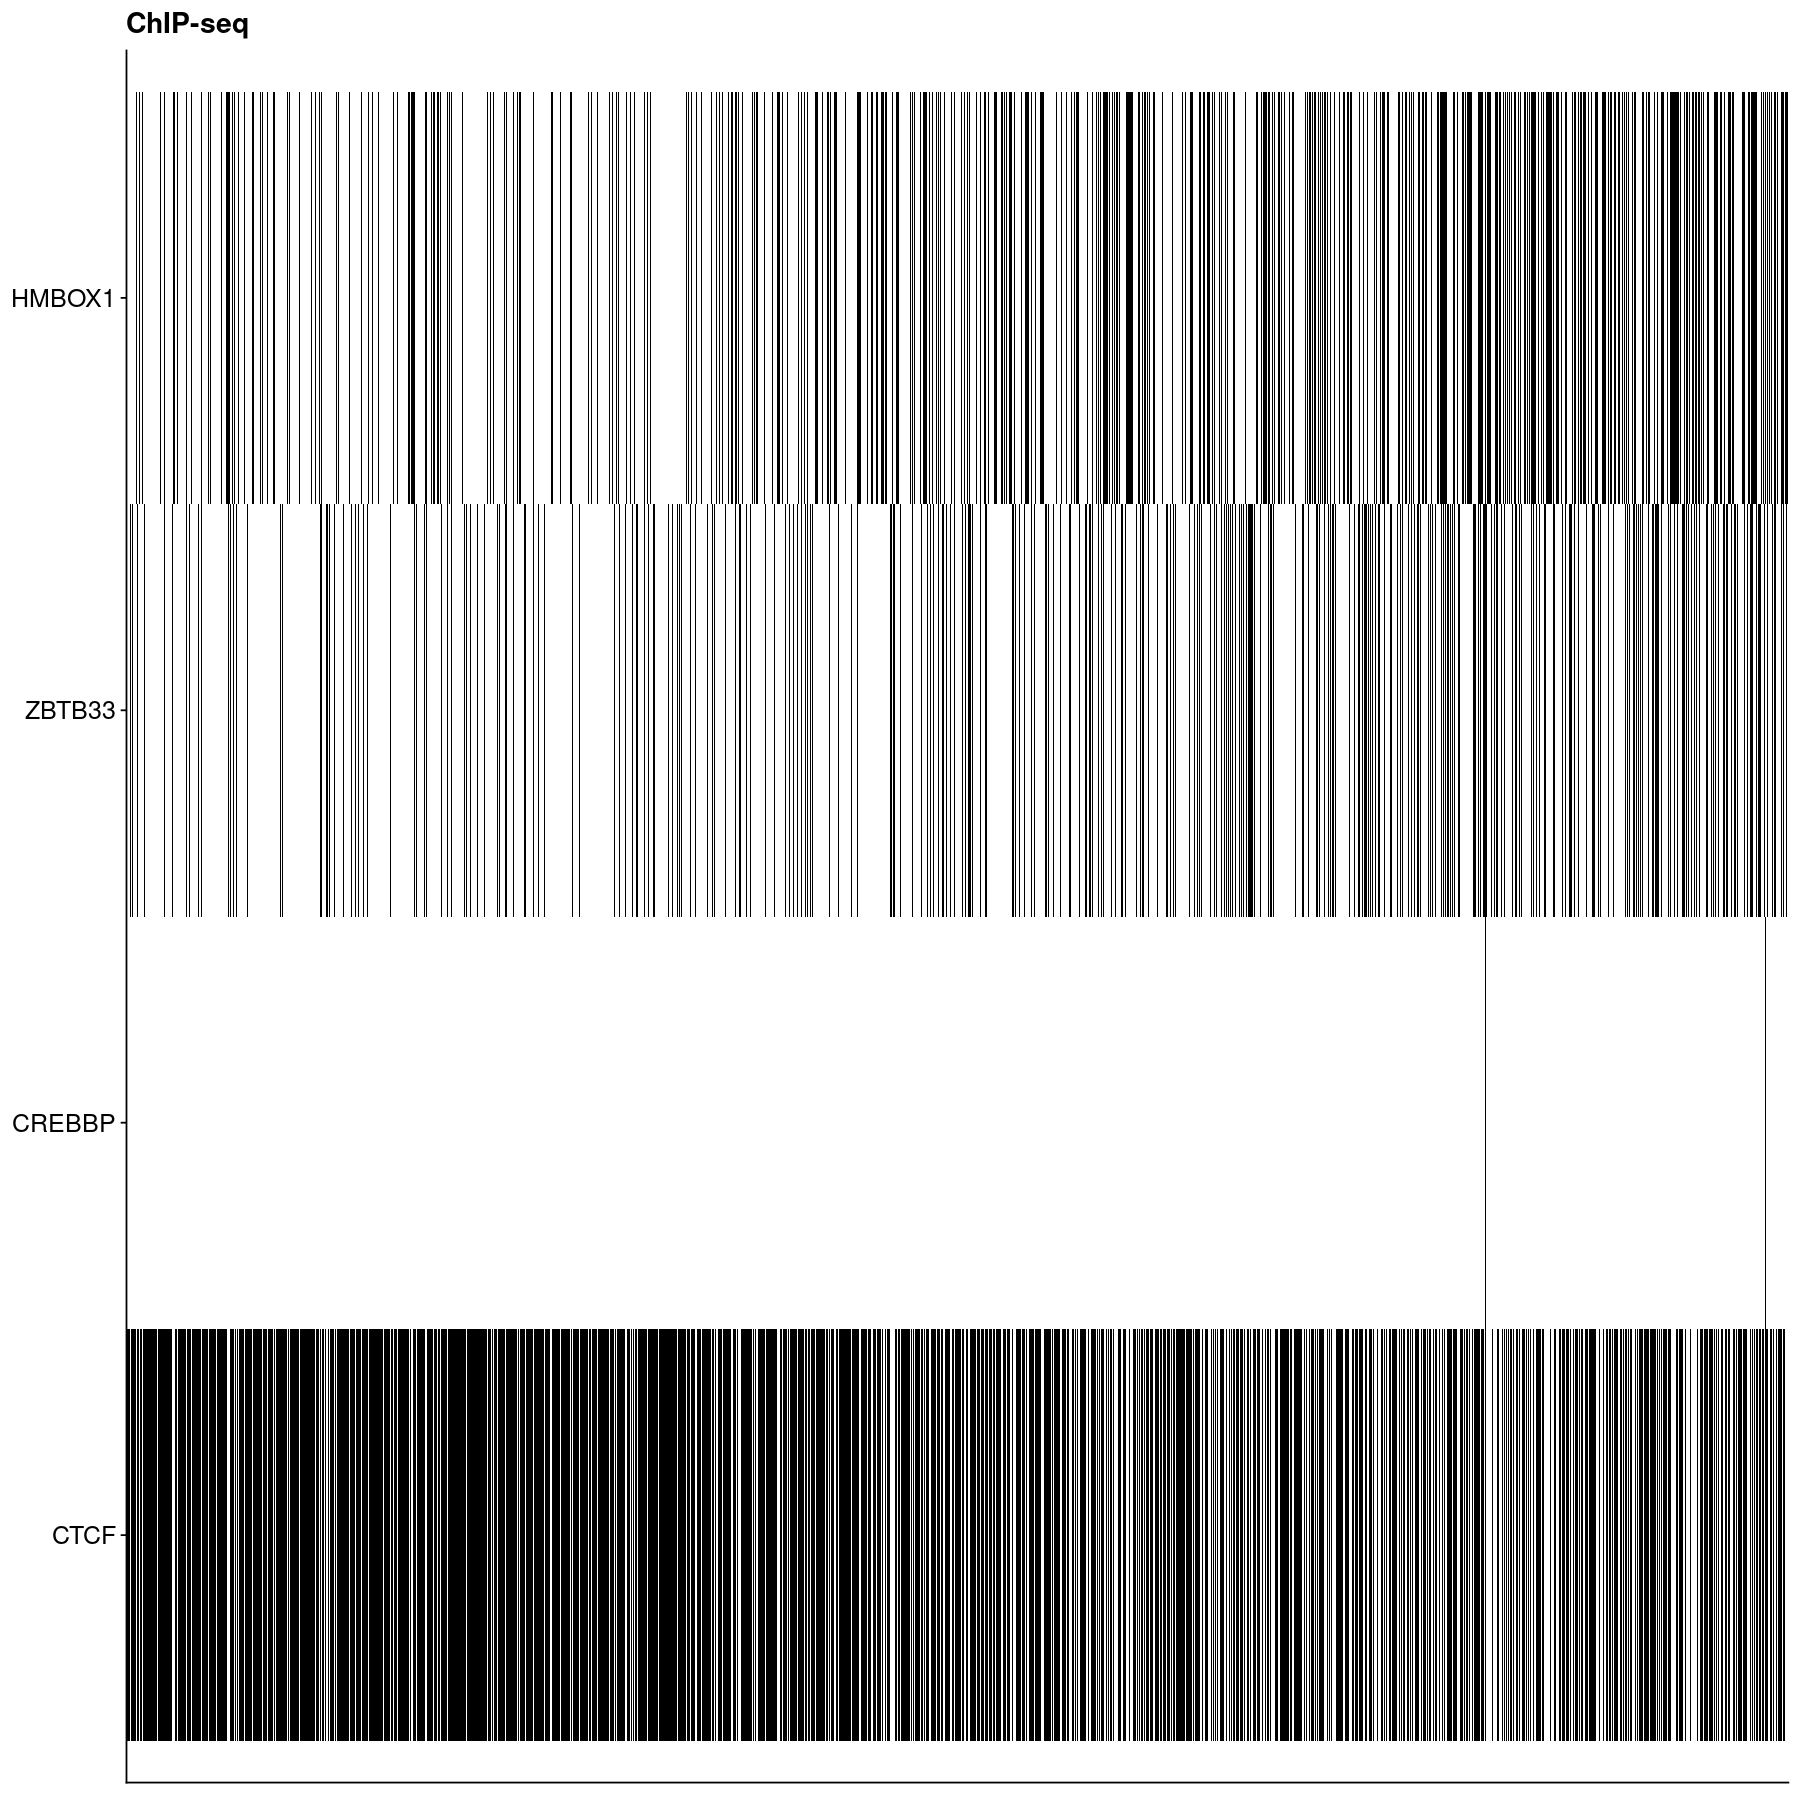

In [18]:
#dat = dat_region_annot

theme_fill   = scale_fill_manual(values = c("1" = "black", "0" = "white"))
theme_text   = THEME_TEXT
theme_legend = theme(legend.position = "none")

txt = "ChIP-seq"
gpt = ggplot(dat, aes(x=Region, y=Label, fill=Value)) +
    geom_tile() +
    labs(title = txt) +
    theme_cowplot() +
    theme_fill +
    theme_text +
    theme_legend
gpt_annot = gpt

options(repr.plot.height=15, repr.plot.width=15)
print(gpt)

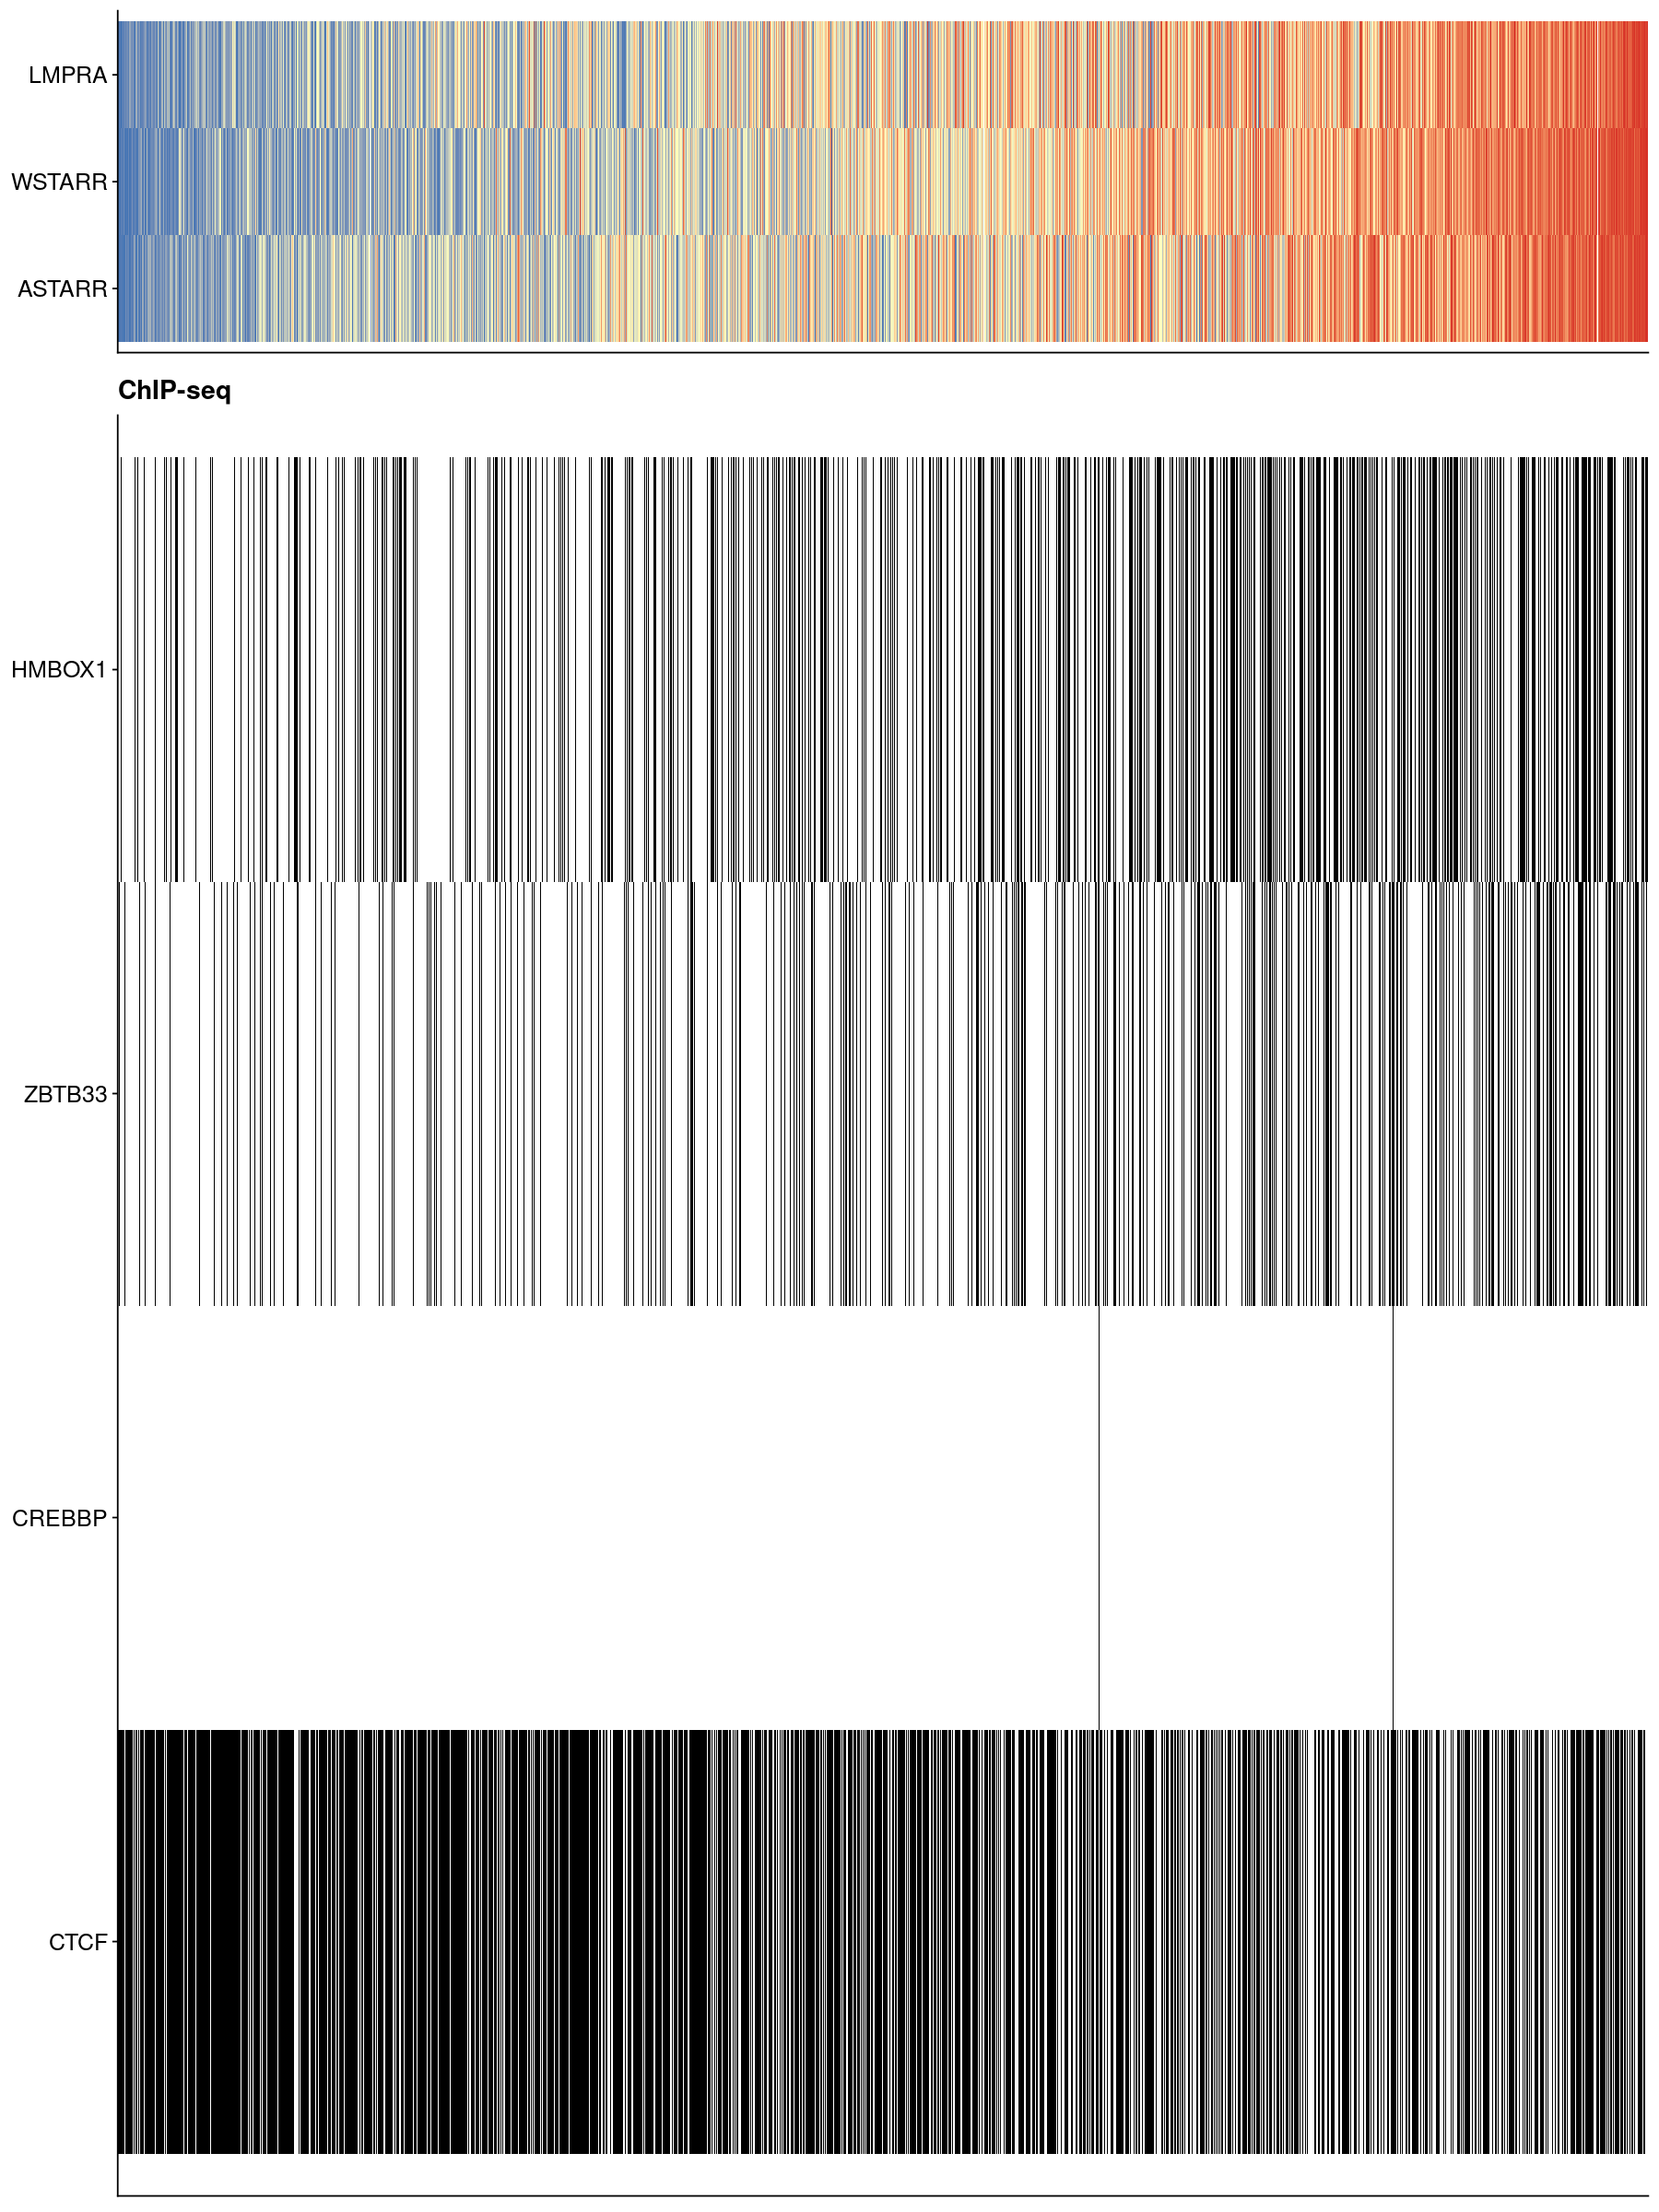

In [19]:
lst_gpt = list(
    gpt_score_starrmpra,
    gpt_annot 
)
options(repr.plot.height=20, repr.plot.width=15)
plt = plot_grid(
    plotlist = lst_gpt,
    ncol=1,
    align="v",
    rel_heights = c(1, 5)
)
plt